<a href="https://colab.research.google.com/github/yox19/fMRI-Neuroimaging-Project/blob/main/A_Pilot_Nilearn_Based_fMRI_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1 - Setup

In [ ]:
# install Nilearn using the apt-get command in Google Colab environment
!apt-get update -qq && apt-get install -y datalad git-annex
!pip install nilearn nibabel matplotlib


In [ ]:
# Clone dataset
!datalad clone https://github.com/OpenNeuroDatasets/ds003999.git
%cd ds003999


STEP 2 - Import libraries

In [ ]:
from nilearn import datasets, image, plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import matplotlib.pyplot as plt
import os


STEP 3 - Define Files

In [ ]:
# creat Dictionary for pre and post rehab files to allow combined DwnL and analysis
pre_files = [
    'sub-00/ses-pre/func/sub-00_ses-pre_task-rest_bold.nii.gz',
    'sub-01/ses-pre/func/sub-01_ses-pre_task-rest_bold.nii.gz',
    'sub-02/ses-pre/func/sub-02_ses-pre_task-rest_bold.nii.gz',
    'sub-03/ses-pre/func/sub-03_ses-pre_task-rest_bold.nii.gz',
    'sub-05/ses-pre/func/sub-05_ses-pre_task-rest_bold.nii.gz'
]
post_files = [
    'sub-00/ses-post/func/sub-00_ses-post_task-rest_bold.nii.gz',
    'sub-01/ses-post/func/sub-01_ses-post_task-rest_bold.nii.gz',
    'sub-02/ses-post/func/sub-02_ses-post_task-rest_bold.nii.gz',
    'sub-03/ses-post/func/sub-03_ses-post_task-rest_bold.nii.gz',
    'sub-05/ses-post/func/sub-05_ses-post_task-rest_bold.nii.gz'
]


In [ ]:
# Download small NIfTI files
for f in pre_files + post_files:
    !datalad get "{f}"


STEP 4 - Load Atlas and define ROIs

In [ ]:
# import Harvard_Oxford atlas commonly used
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps
labels = atlas.labels


In [ ]:
# select and label specific ROI
motor_indices = [i for i, label in enumerate(labels)
                 if any(k in label for k in ["Precentral", "Postcentral", "Supplementary Motor"])]
print("Motor ROI indices:", motor_indices)

masker = NiftiLabelsMasker(labels_img=atlas_filename,
                           standardize='zscore_sample', detrend=True, t_r=2.0,
                           resampling_target='labels')

conn_measure = ConnectivityMeasure(kind='correlation')

Motor ROI indices: [7, 17, 26]


STEP 5 - Compute connectivity

In [ ]:
from nilearn.connectome import ConnectivityMeasure
from nilearn import image
import numpy as np
import os

conn_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample"
)

# Fit masker ONCE
first_img = image.load_img(pre_files[0])
masker.fit(first_img)

def compute_connectivity(func_files):
    conn_mats = []
    for f in func_files:
        if os.path.exists(f):
            img = image.load_img(f)
            ts = masker.transform(img)          # FAST
            conn = conn_measure.fit_transform([ts])[0]
            conn_mats.append(conn)
    return np.mean(conn_mats, axis=0)

mean_pre  = compute_connectivity(pre_files)
mean_post = compute_connectivity(post_files)
mean_diff = mean_post - mean_pre

STEP 6 - Visualize

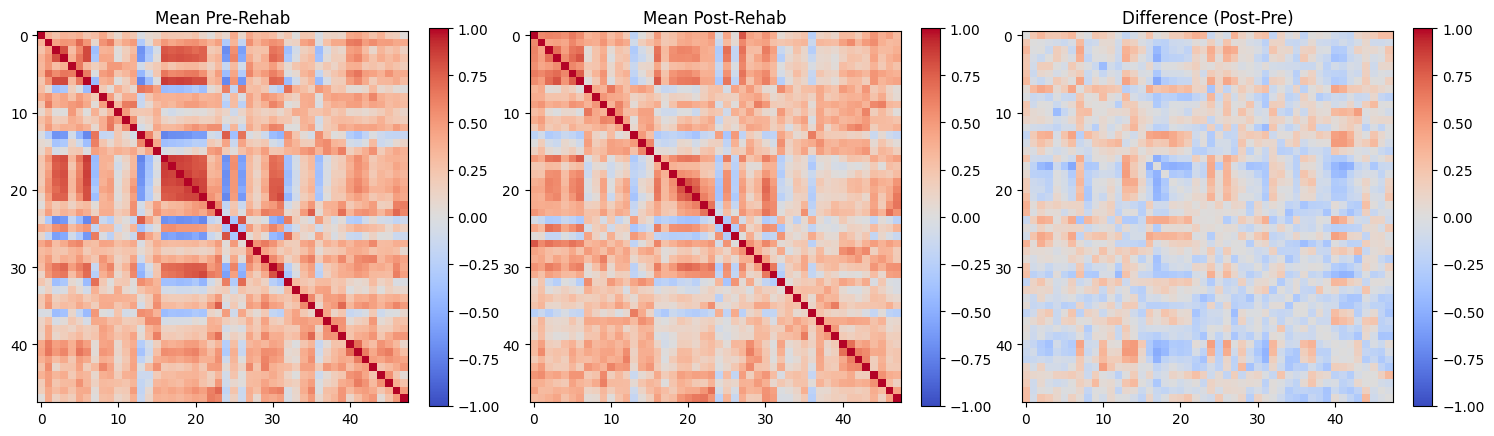

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, mat, title in zip(axes,
                          [mean_pre, mean_post, mean_diff],
                          ['Mean Pre-Rehab', 'Mean Post-Rehab', 'Difference (Post-Pre)']):
    im = ax.imshow(mat, vmin=-1, vmax=1, cmap='coolwarm')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046)
plt.show()


In [ ]:
# Focused motor ROI difference
motor_pre = mean_pre[np.ix_(motor_indices, motor_indices)]
motor_post = mean_post[np.ix_(motor_indices, motor_indices)]
motor_diff = motor_post - motor_pre

print("Average motor network change:", np.mean(motor_diff))


Average motor network change: 0.08740183


Motor matrix and Anatomic Overly

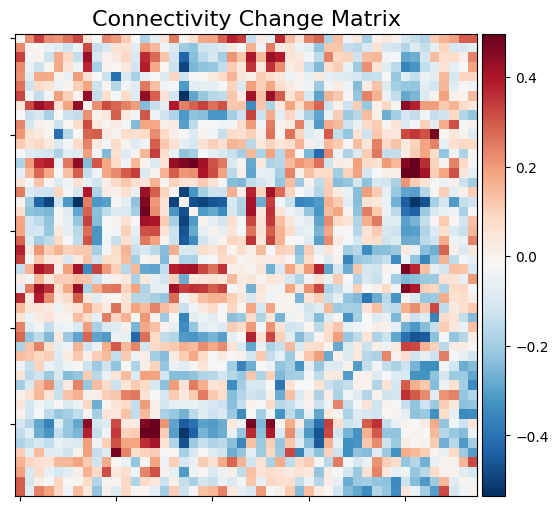

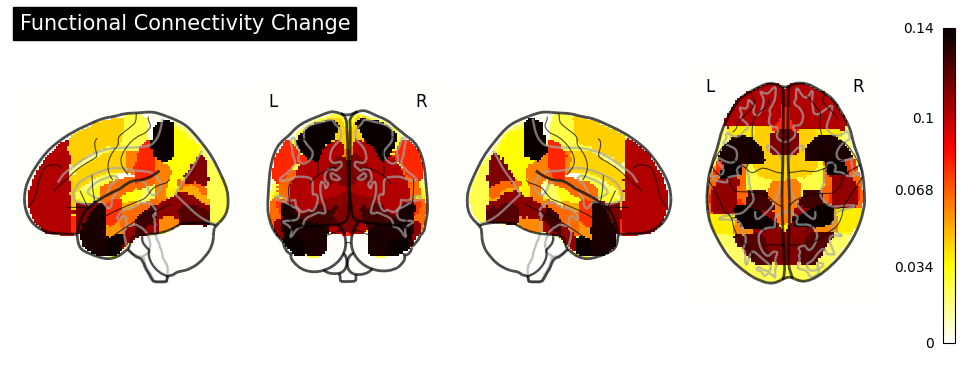

In [ ]:
plotting.plot_matrix(mean_diff, figure=(6,5), colorbar=True, title='Connectivity Change Matrix')
plotting.plot_glass_brain(masker.inverse_transform(np.mean(mean_diff, axis=0)),
                          display_mode='lyrz', colorbar=True,
                          title='Functional Connectivity Change')
plotting.show()

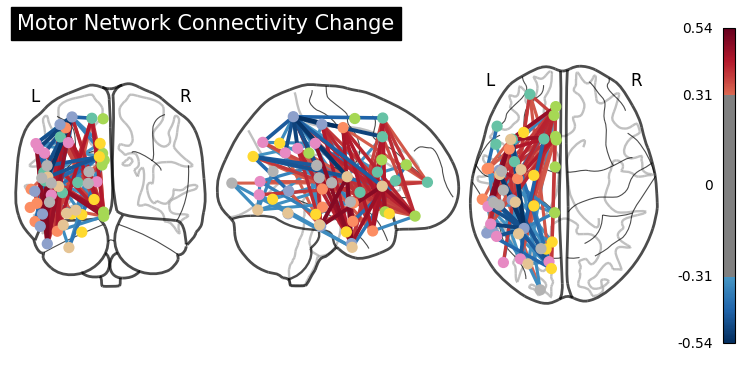

In [ ]:
# plot Motor network conncetivity
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
plotting.plot_connectome(mean_diff, coords, edge_threshold='90%',
                title='Motor Network Connectivity Change')

# Note: No confound regression applied (motion/physio not available in dtaset).
# Connectivity results should be intepreted as exploratory.